# 0.0 Imports

In [1]:
import pandas              as pd
import numpy               as np
import seaborn             as sns
import matplotlib.pyplot   as plt
import scipy.stats         as ss
import xgboost             as xgb

import inflection
import math
import datetime
import random
import warnings
import pickle
import requests

warnings.filterwarnings('ignore')


from IPython.display     import Image
from boruta              import BorutaPy
from matplotlib.gridspec import GridSpec
from tabulate            import tabulate

from sklearn.ensemble      import RandomForestRegressor
from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.linear_model  import LinearRegression, Lasso
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder


## 0.1 Helper Functions

In [2]:
def mean_absolute_percentage_error(y,yhat):
    return np.mean(np.abs((y-yhat)/y))


def ml_error(model_name, y, yhat):
    mae = mean_absolute_error(y,yhat)
    mape = mean_absolute_percentage_error(y,yhat)    
    rmse = np.sqrt(mean_squared_error(y,yhat))
    
    return pd.DataFrame( {'Model Name': model_name,
                          'MAE': mae,
                          'MAPE': mape,
                          'RMSE': rmse}, index=[0] )

def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list=[]
    mape_list=[]
    rmse_list=[]
    for k in reversed(range(1,kfold+1)):
        if verbose:
            print('\nKFold Number: {}'.format(k))
            
        # start and end date for validation
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        #filtering dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # training dataset
        xtraining = training.drop(['date','sales'], axis = 1)
        ytraining = training['sales']

        # validation dataset
        xvalidation = validation.drop(['date','sales'], axis = 1)
        yvalidation = validation['sales']

        # model
        m = model.fit(xtraining, ytraining)

        # prediction
        yhat = m.predict(xvalidation)

        # performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(yhat))

        # store performance of each kfold iteration
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame( {'Model name': model_name,
                          'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list),2).astype(str),
                          'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list),2).astype(str),
                          'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list),2).astype(str)                  
                         }, index=[0] )


def cramer_v(x,y):
    cm = pd.crosstab(x,y).values
    chi2 = ss.chi2_contingency(cm)[0]
    n = cm.sum()
    r, k = cm.shape
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)    
    return np.sqrt((chi2corr/n) / (min(kcorr-1,rcorr-1)))

## 0.2 Loading Data

In [2]:
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

# 1.0 Data Description

In [3]:
df1 = df_raw.copy()

## 1.1 Rename Columns

In [5]:
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [6]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

snakecase = lambda x: inflection.underscore(x)
cols_new = list(map( snakecase, cols_old))
df1.columns = cols_new

## 1.2 Data Dimensions

In [7]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of columns: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of columns: 18


## 1.3 Data Types

In [8]:
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 Check NA

In [9]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5 Fillout NA

In [10]:
df1['competition_distance'].max()

75860.0

In [11]:
#competition distance
df1.competition_distance.fillna(200000, inplace=True)

#competition open since month
df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

#competition open since year
df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

#promo2 since week
df1.promo2_since_week.fillna(df1.date.dt.isocalendar().week, inplace=True)

#promo2 since year
df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

#promo interval
month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

df1.promo_interval.fillna(0, inplace= True)

df1['month_map'] = df1['date'].dt.month.map(month_map)

df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [12]:
df1.sample(5).T

,151645,253578,389470,466275,399898
store,6,441,824,991,990
day_of_week,2,6,1,6,4
date,2015-03-17 00:00:00,2014-12-13 00:00:00,2014-07-21 00:00:00,2014-05-10 00:00:00,2014-07-10 00:00:00
sales,5711,7413,6457,6804,4877
customers,637,766,916,648,498
open,1,1,1,1,1
promo,1,0,0,0,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,0,0
store_type,a,d,a,a,d


## 1.6 Change Types

In [13]:
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

## 1.7 Descriptive Statistical

In [14]:
# Selection based on data type
num_attributes = df1.select_dtypes(include=['int32','int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude=['int64','int32', 'float64', 'datetime64[ns]'])

In [15]:
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int32
promo2_since_year                        int32
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7.1 Numerical Attributes

In [16]:
# Central Tendency - mean, median
ct1 = pd.DataFrame(num_attributes.apply(np.mean)).T
ct2 = pd.DataFrame(num_attributes.apply(np.median)).T

# Dispersion - Standard deviation, minimal, maximum, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T
d2 = pd.DataFrame(num_attributes.apply(min)).T
d3 = pd.DataFrame(num_attributes.apply(max)).T
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# Concatenate
m = pd.concat([d2,d3,d4,ct1,ct2,d1,d5,d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

<AxesSubplot:xlabel='sales', ylabel='Density'>

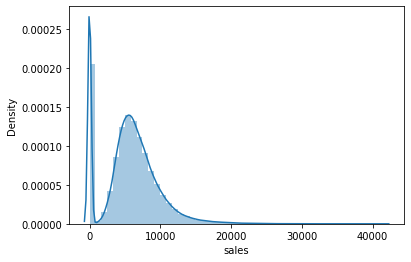

In [17]:
sns.distplot(df1['sales'])

## 1.7.2 Categorical Attributes

In [18]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

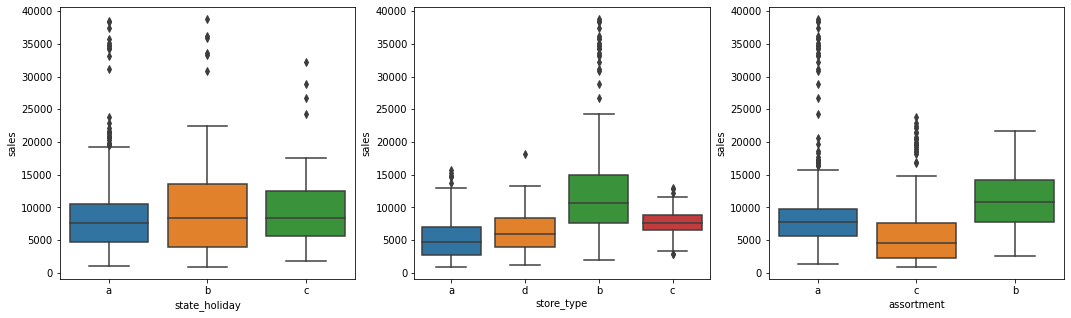

In [19]:
aux1 = df1[(df1.state_holiday != '0') & (df1.sales > 0)]
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.boxplot(x='state_holiday',y='sales',data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type',y='sales',data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment',y='sales',data=aux1)

# 2.0 Feature Engineering

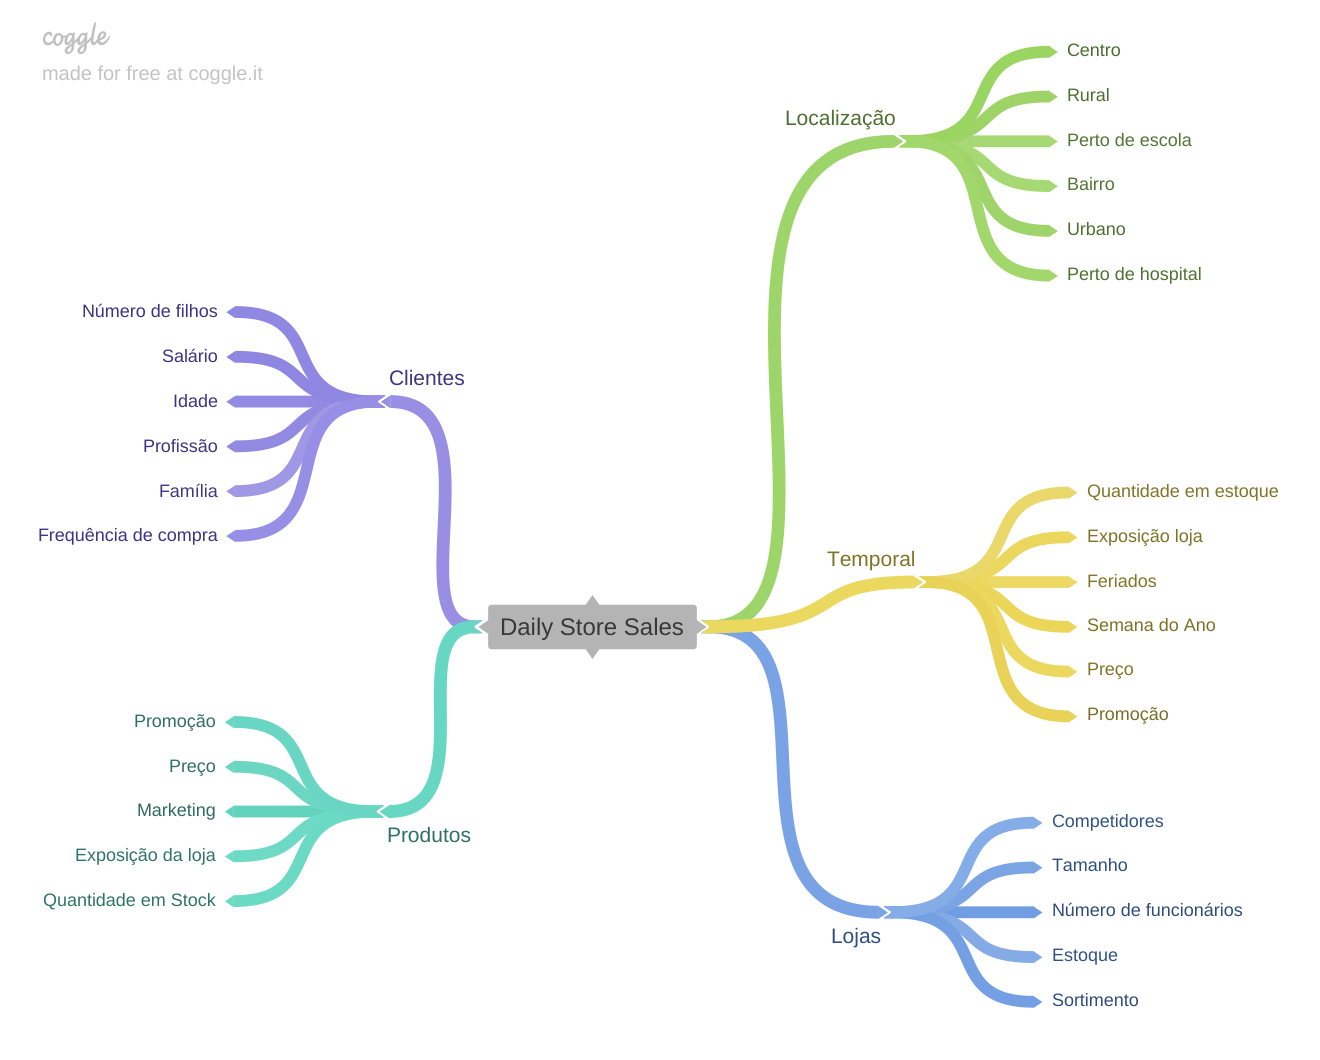

In [20]:
Image('img/Daily_Store_Sales.png')

## 2.1 Hypothesis Creation

In [21]:
df2 = df1.copy()

### 2.1.1 Store Hypothesis

**1.** Lojas com maior quadro de funcionários deveriam vender mais

**2.** Lojas com maior estoque deveriam vender mais

**3.** Lojas com maior porte deveriam vender mais

**4.** Lojas com menor portre deveriam vender menos

**5.** Lojas com maior sortimento deveriam vender mais

### 2.1.2 Product Hypothesis

**1.** Lojas que investem mais em Marketing deveriam vender mais

**2.** Lojas que expõe mais os produtos nas vitrinas deveriam vender mais

**3.** Lojas que tem preços menores nos produtos deveriam vender mais

**4.** Lojas que tem preços menores por mais tempo nos produtos deveriam vender mais

### 2.1.3 Time Hypothesis

**1.** Lojas que tem mais feriados deveriam vender menos

**2.** Lojas que abrem nos primeiros 6 meses deveriam vender mais

**3.** Lojas que abrem nos finais de semana deveriam vender mais

## 2.2 Hypothesis Final List

**1.** Lojas com maior sortimento deveriam vender mais

**2.** Lojas com competidores mais próximos deveriam vender menos

**3.** Lojas com competidores à mais tempo deveriam vender mais

**4.** Lojas com promoções ativas por mais tempo deveriam vender mais

**5.** Lojas com mais dias de promoção deveriam vender mais

**6.** Lojas com mais proomoções consectutivas deveriam vender mais

**7.** Lojas abertas durante o feriado de natal deveriam vender mais

**8.** Lojas deveriam vender mais ao longo do sanos

**9.** Lojas deveriam vender mais depois do dia 10 de cada mês

**10.** Loajs deveriam vender menos aos finais de semana

**11.** Lojas deveriam vender menos durante os feriados escolares


## 2.3 Feature Engineering

In [22]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.isocalendar().week

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

# competition since
df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)
df2['promo_since'] = df2.promo_since.apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
df2['promo_time_week'] = (( df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

# assortment
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')


In [23]:
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 Filtering Variables

In [24]:
df3 = df2.copy()

## 3.1 Filtering Lines

In [25]:
df3 = df3[(df3['open']  != 0) & (df3['sales'] > 0)]

## 3.2 Columns Selection

In [26]:
cols_drop = ['customers','open','promo_interval','month_map']
df3 = df3.drop(cols_drop, axis = 1)

In [27]:
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 Exploratory Data Analysis

In [28]:
df4 = df3.copy()

## 4.1 Univariate Analysis

### 4.1.1 Response Variable

<AxesSubplot:xlabel='sales', ylabel='Density'>

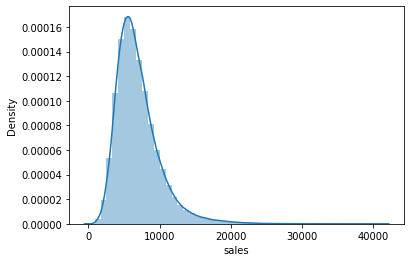

In [29]:
sns.distplot(df4.sales)

### 4.1.2 Numerical Variable

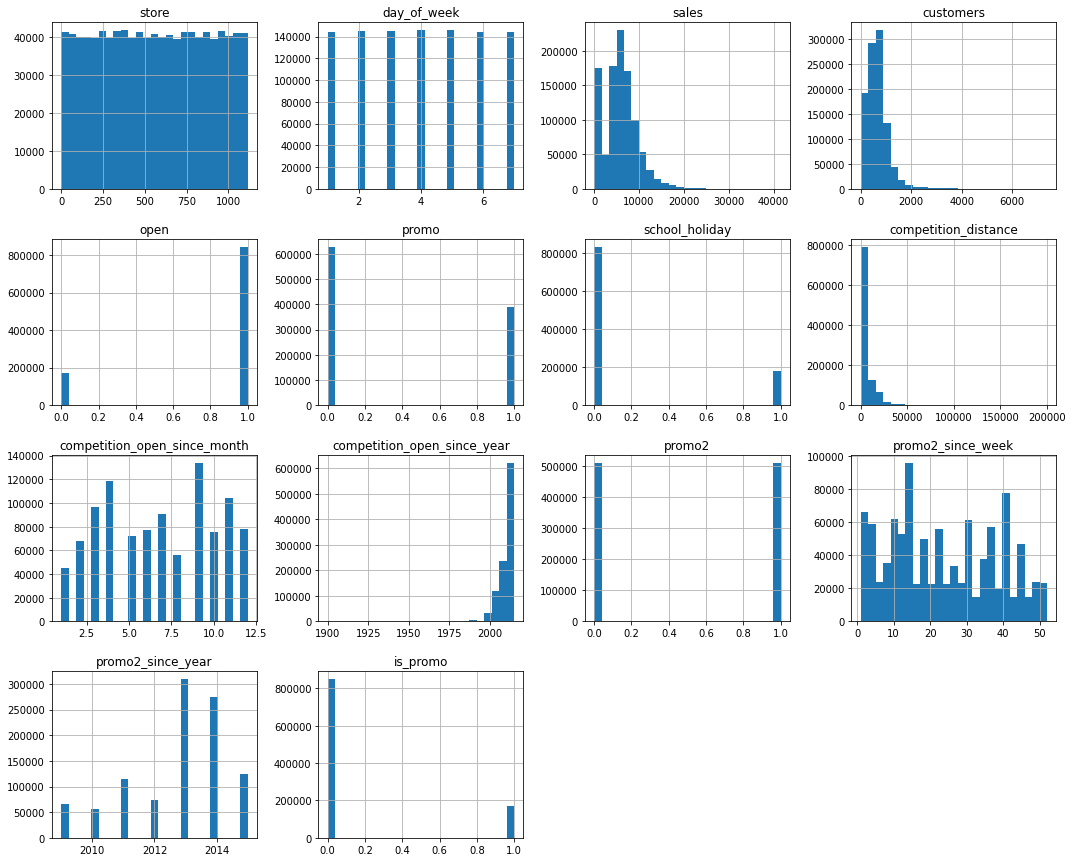

In [30]:
num_attributes.hist(bins=25, figsize=(18,15));


### 4.1.3 Categorical Variable

In [31]:
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

<AxesSubplot:xlabel='sales', ylabel='Density'>

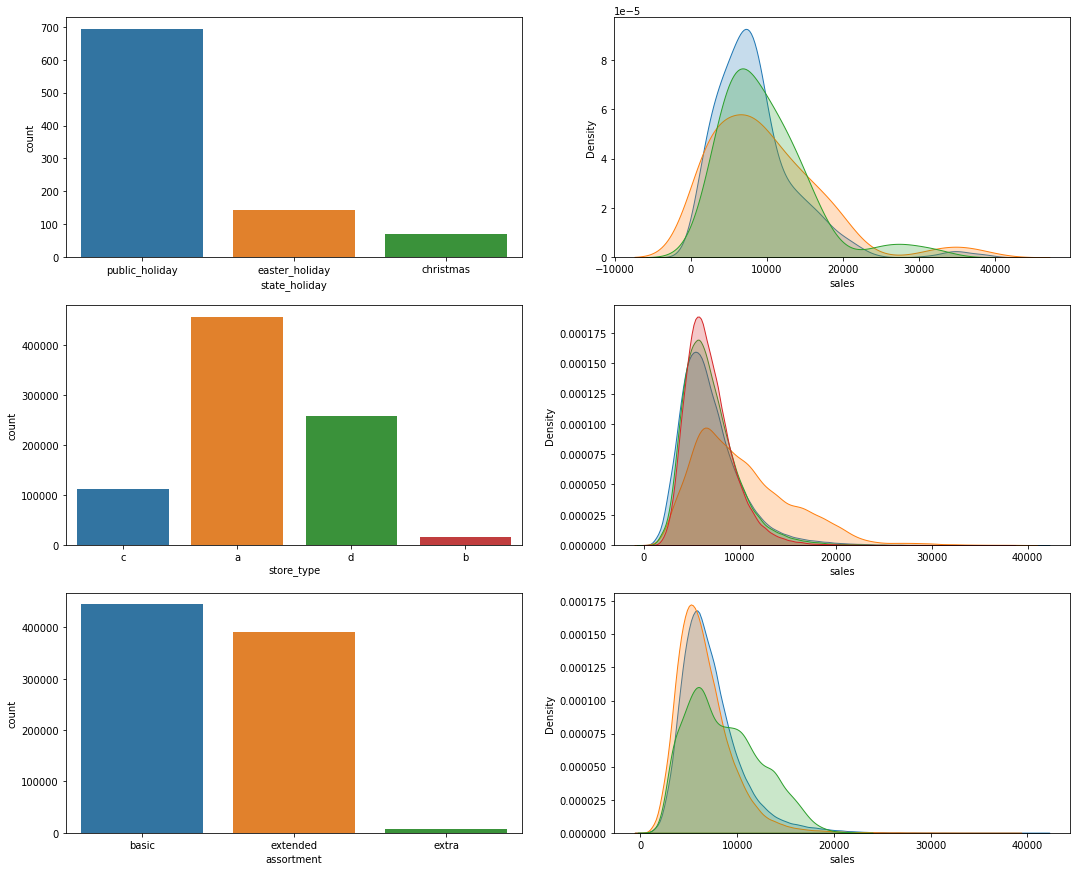

In [32]:
# state holiday
plt.figure(figsize=(18,15))
plt.subplot(3,2,1)
a = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(data=a, x='state_holiday')

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)

# store type
plt.subplot(3,2,3)
sns.countplot(data=df4, x='store_type')

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(data=df4, x='assortment')

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)


## 4.2 Bivariate Analysis

### H1. Lojas com maior sortimentos deveriam vender mais
**Falsa:** Lojas com **maior** sortimento vendem **menos**

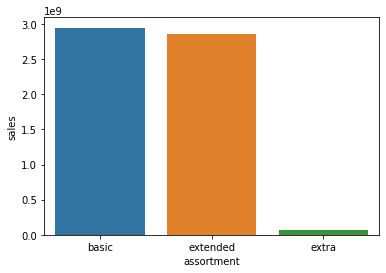

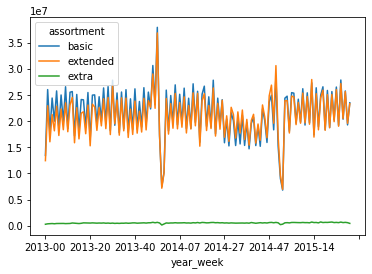

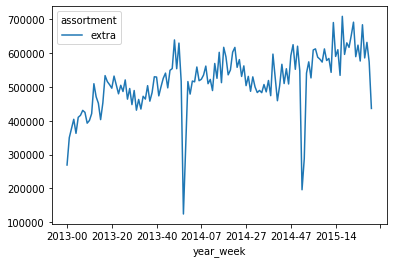

In [33]:
aux1 = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux1, x='assortment', y='sales');

aux2 = df4[['year_week','assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
aux2.pivot(index='year_week', columns='assortment', values='sales').plot();

aux3 = aux2[aux2['assortment'] == 'extra']
aux3.pivot(index='year_week', columns='assortment', values='sales').plot();

### H2. Lojas com competidores mais próximos deveriam vender menos
**Falsa** Lojas com competidores **mais próximos** vendem **mais**

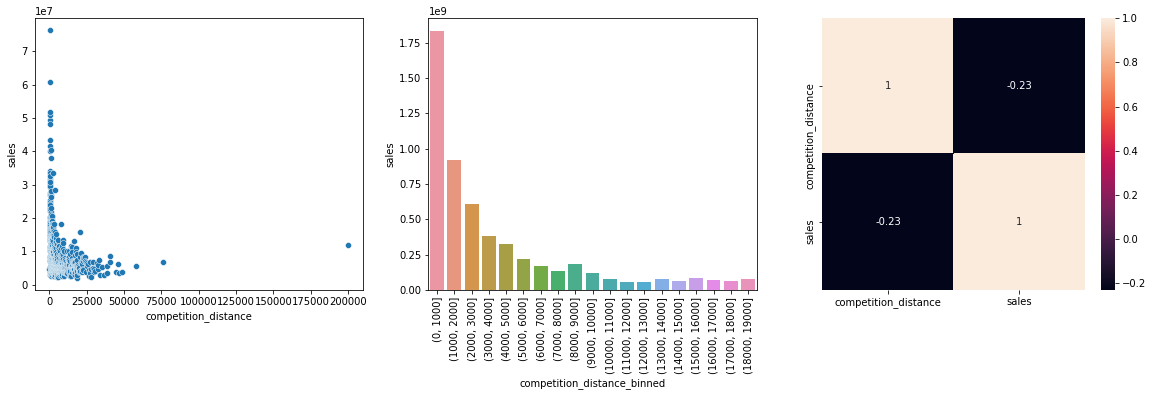

In [34]:
aux1 = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(20,5));

plt.subplot(1,3,1);
sns.scatterplot(x='competition_distance', y='sales', data=aux1);


plt.subplot(1,3,2)
bins = list(np.arange(0,20000,1000))
aux1['competition_distance_binned'] = pd.cut(aux1['competition_distance'], bins=bins)
aux2 = aux1[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()

sns.barplot(x='competition_distance_binned', y='sales', data=aux2,);
plt.xticks(rotation=90);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot=True);

### H3. Lojas com competidores à mais tempo deveriam vender mais
**Falsa** Lojas com competidores à **mais tempo** vendem **menos**

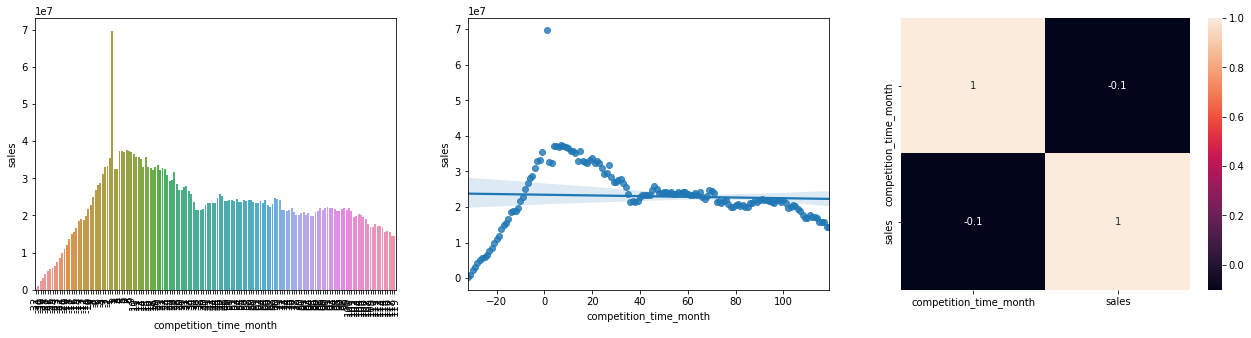

In [35]:
plt.figure(figsize=(22,5));
plt.subplot(1,3,1)
aux1 = df4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux2 = aux1[(aux1['competition_time_month'] < 120) & (aux1['competition_time_month'] != 0)]
sns.barplot(x='competition_time_month', y='sales', data=aux2)
plt.xticks(rotation=90)

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux2);

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(), annot=True);

            
            

### H4. Lojas com promoções ativas por mais tempo deveriam vender mais
**Falsa** Lojas com promoções ativas por mais tempo vendem menos, depois de um certo período de promoção

<AxesSubplot:>

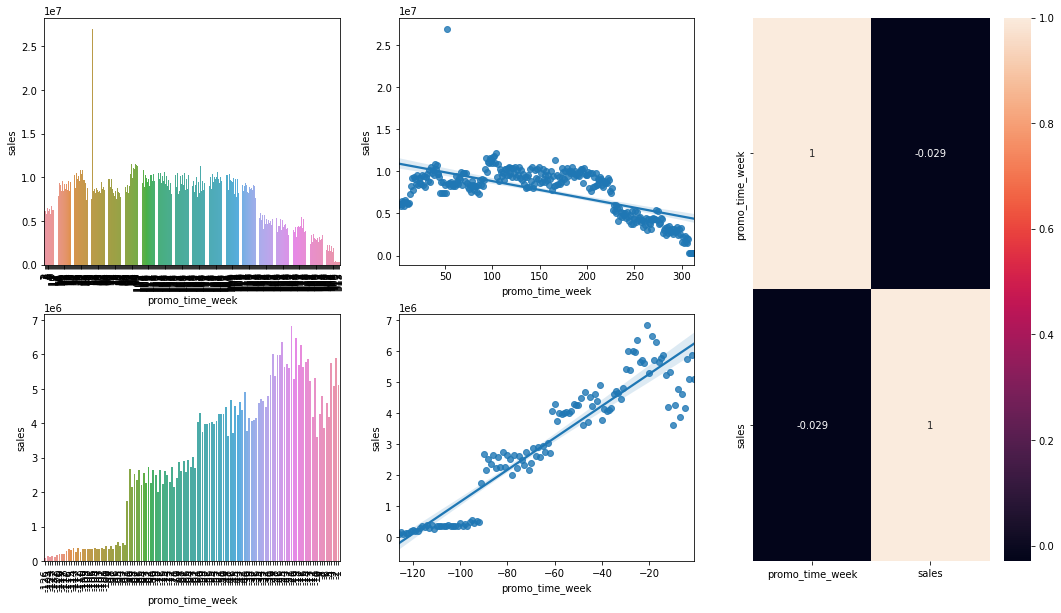

In [36]:
aux1 = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()

grid = GridSpec(2,3)
plt.figure(figsize=(18,10))

plt.subplot(grid[0,0])
aux2 = aux1[aux1['promo_time_week'] > 0] #promo extendido
sns.barplot(x='promo_time_week',y='sales',data=aux2)
plt.xticks(rotation=90)

plt.subplot(grid[0,1])
sns.regplot(x='promo_time_week',y='sales',data=aux2)

plt.subplot(grid[1,0])
aux3 = aux1[aux1['promo_time_week'] < 0] #promo regular
sns.barplot(x='promo_time_week', y='sales',data=aux3)
plt.xticks(rotation=90)

plt.subplot(grid[1,1])
sns.regplot(x='promo_time_week',y='sales',data=aux3)

plt.subplot(grid[:,2])
sns.heatmap(aux1.corr(method='pearson'),annot=True)


 ## <s> H5. Lojas com mais dias de promoção deveriam vender mais </s>

## H7. Lojas com mais promoções consecutivas deveriam vender mais
**Falsa** Lojas com mais promoções consecutivas vendem menos

In [37]:
df4[['promo','promo2','sales']].groupby(['promo','promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


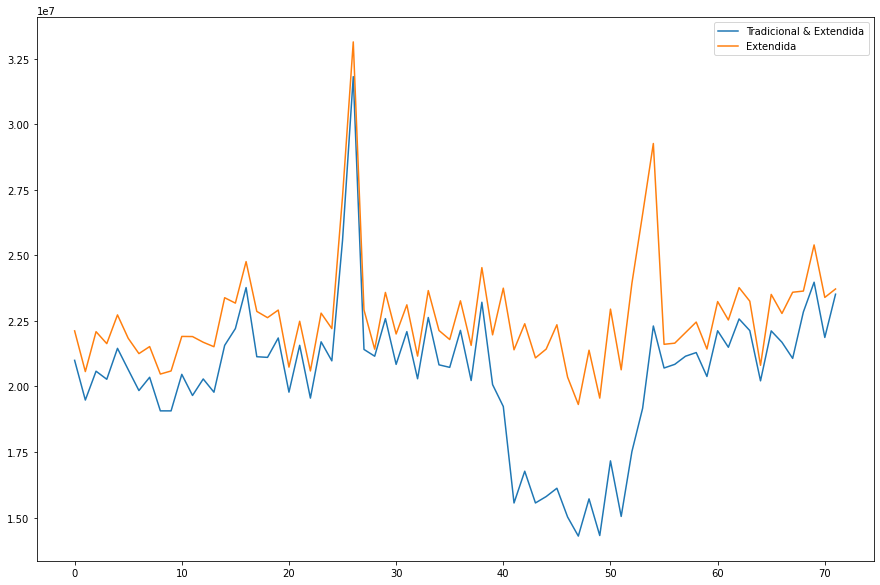

In [38]:
aux1 = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week','sales']].groupby('year_week').sum().reset_index()
ax = aux1.plot(figsize=(15,10));

aux2 = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week','sales']].groupby('year_week').sum().reset_index()
aux2.plot(ax=ax);



ax.legend(labels=['Tradicional & Extendida', 'Extendida']);


## **H8.** Lojas abertas durante o feriado de Natal deveriam vender mais
**Falsa** Lojas abertas durante o Natal vendem menos

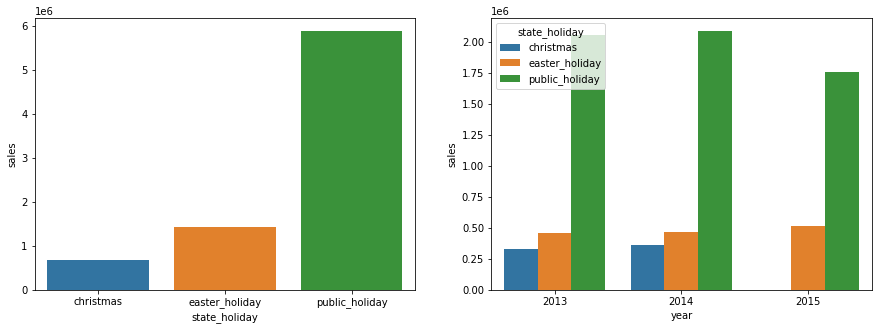

In [39]:
aux = df4[df4['state_holiday'] != 'regular_day']


plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
aux1 = aux[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(x='state_holiday', y='sales',data=aux1);


plt.subplot(1,2,2)
aux2 = aux[['year','state_holiday','sales']].groupby(['year','state_holiday']).sum().reset_index()
sns.barplot(x='year',y='sales', hue='state_holiday',data=aux2);



## H8. Lojas deveriam vender mais ao longo dos anos
**Falsa** Lojas vendem menos ao longo dos anos

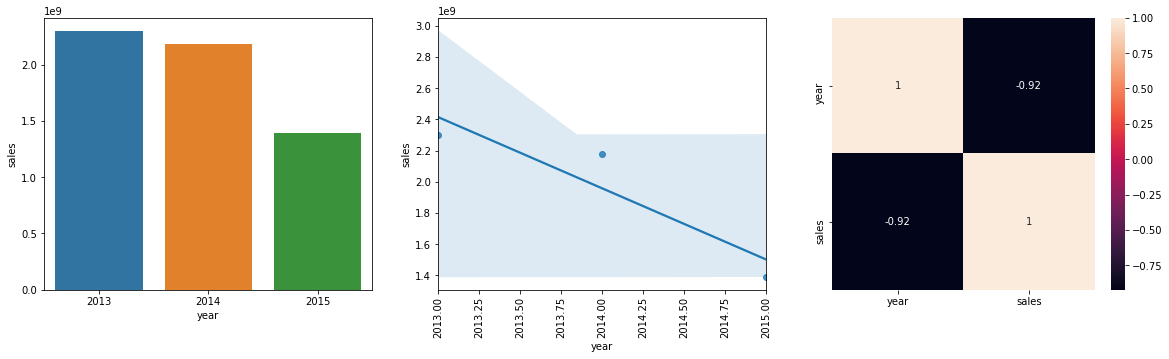

In [40]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
aux1 = df4[['year','sales']].groupby('year').sum().reset_index()
sns.barplot(x='year',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='year',y='sales',data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## H8. Lojas deveriam mais no segundo semestre do ano
**Falsa** Lojas vendem menos no segundo semestre do ano

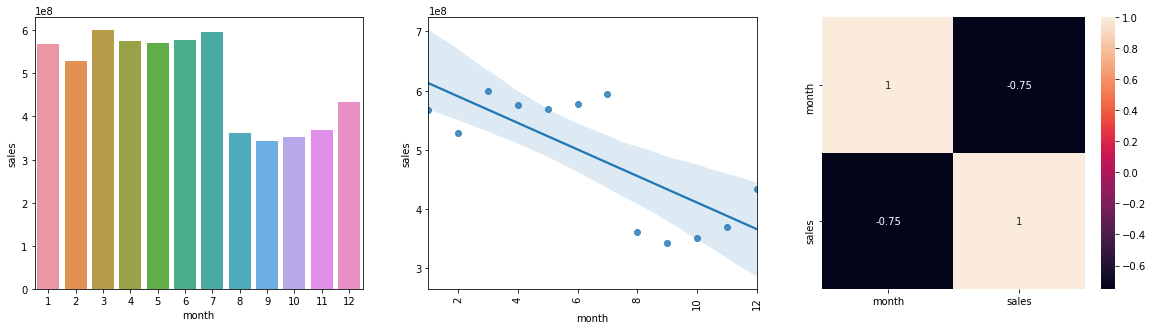

In [41]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
aux1 = df4[['month','sales']].groupby('month').sum().reset_index()
sns.barplot(x='month',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='month',y='sales',data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## H11. Lojas deveriam vender mais depois do dia 10 de cada mês
**Verdadeira** Lojas vendem mais depois do dia 10

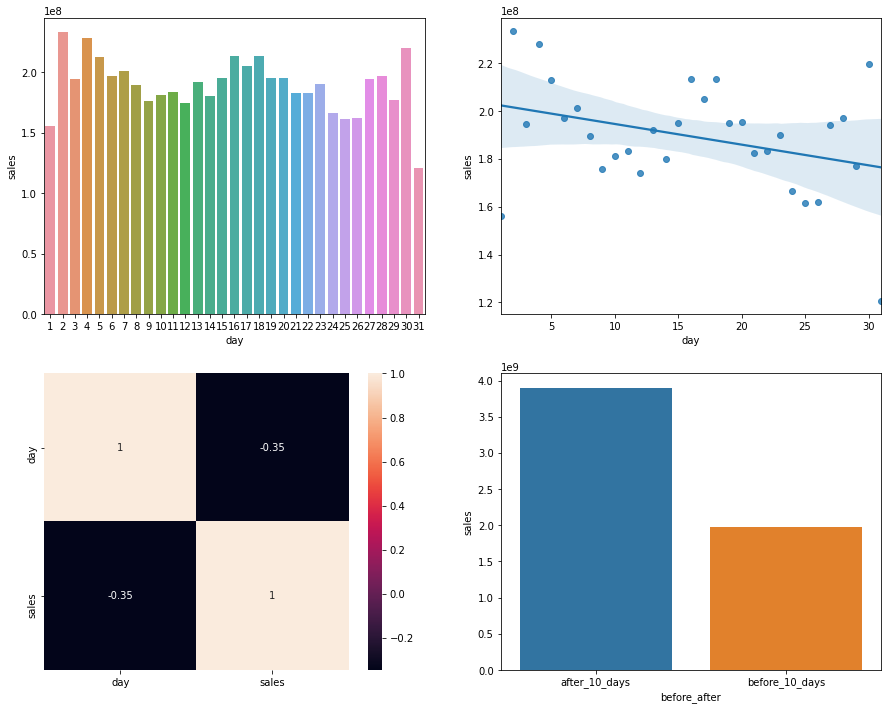

In [42]:
aux1 = df4[['day','sales']].groupby('day').sum().reset_index()

plt.figure(figsize=(15,12))
plt.subplot(2,2,1)
sns.barplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,2)
sns.regplot(x='day',y='sales',data=aux1);

plt.subplot(2,2,3)
sns.heatmap(aux1.corr(method='pearson'),annot=True);

aux1['before_after'] = aux1['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux2 = aux1[['before_after','sales']].groupby('before_after').sum().reset_index()

plt.subplot(2,2,4)
sns.barplot(x='before_after', y='sales', data=aux2);


## H12. Lojas vendem menos nos finais de semana
**Verdadeira** Lojas vendem mais nos finais de semana

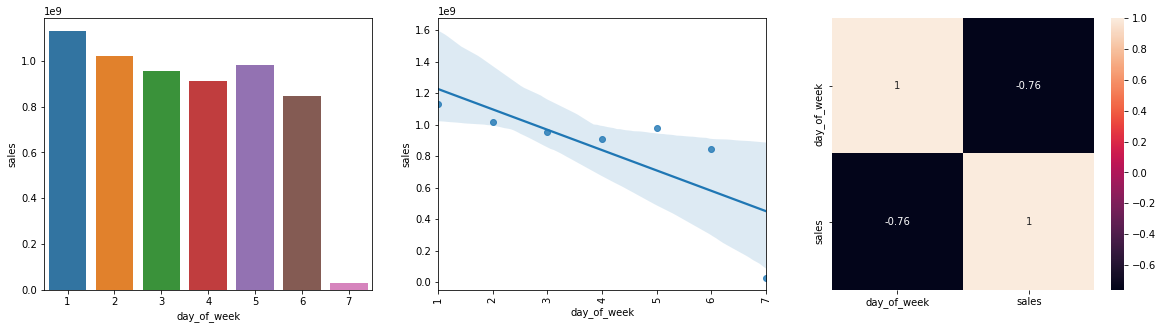

In [43]:
plt.figure(figsize=(20,5))
plt.subplot(1,3,1)
aux1 = df4[['day_of_week','sales']].groupby('day_of_week').sum().reset_index()
sns.barplot(x='day_of_week',y='sales',data=aux1);

plt.subplot(1,3,2)
sns.regplot(x='day_of_week',y='sales',data=aux1);
plt.xticks(rotation=90)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True);

## H13. Lojas deveriam vender menos nos feriados escolares
**Verdadeira** Lojas vendem menos nos feriados escolares, exceto em julho e agosto

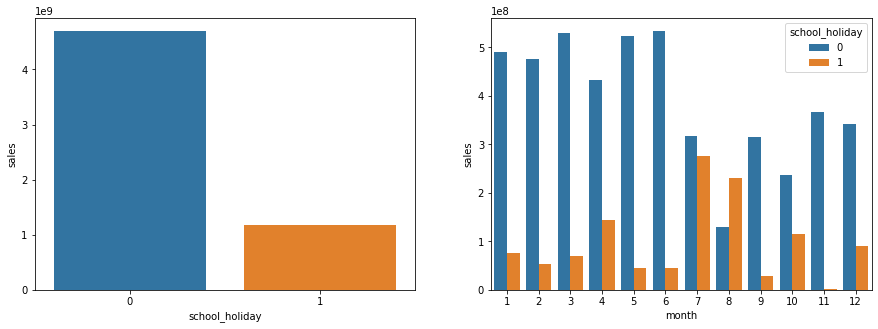

In [44]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
aux1 = df4[['school_holiday','sales']].groupby('school_holiday').sum().reset_index()
sns.barplot(x='school_holiday',y='sales',data=aux1);

plt.subplot(1,2,2)
aux1 = df4[['month','school_holiday','sales']].groupby(['month','school_holiday']).sum().reset_index()
sns.barplot(x='month',y='sales',hue='school_holiday',data=aux1);



### 4.2.1 Resumo das hipóteses

In [45]:
tab = [['Hipoteses','Conclusao','Relevancia'],
     ['H1','Falsa','Baixa'],
     ['H2','Falsa','Media'],
     ['H3','Falsa','Media'],
     ['H4','Falsa','Baixa'],
     ['H5','-','-'],
     ['H7','Falsa','Baixa'],
     ['H8','Falsa','Media'],
     ['H9','Falsa','Alta'],
     ['H10','Falsa','Alta'],
     ['H11','Verdadeira','Alta'],
     ['H12','Verdadeira','Alta'],
     ['H13','Verdadeira','Baixa'],    
    ]

print(tabulate(tab,headers='firstrow'))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H4           Falsa        Baixa
H5           -            -
H7           Falsa        Baixa
H8           Falsa        Media
H9           Falsa        Alta
H10          Falsa        Alta
H11          Verdadeira   Alta
H12          Verdadeira   Alta
H13          Verdadeira   Baixa


## 4.3 Multivariate Analysis

### 4.3.1 Numerical Attributes

<AxesSubplot:>

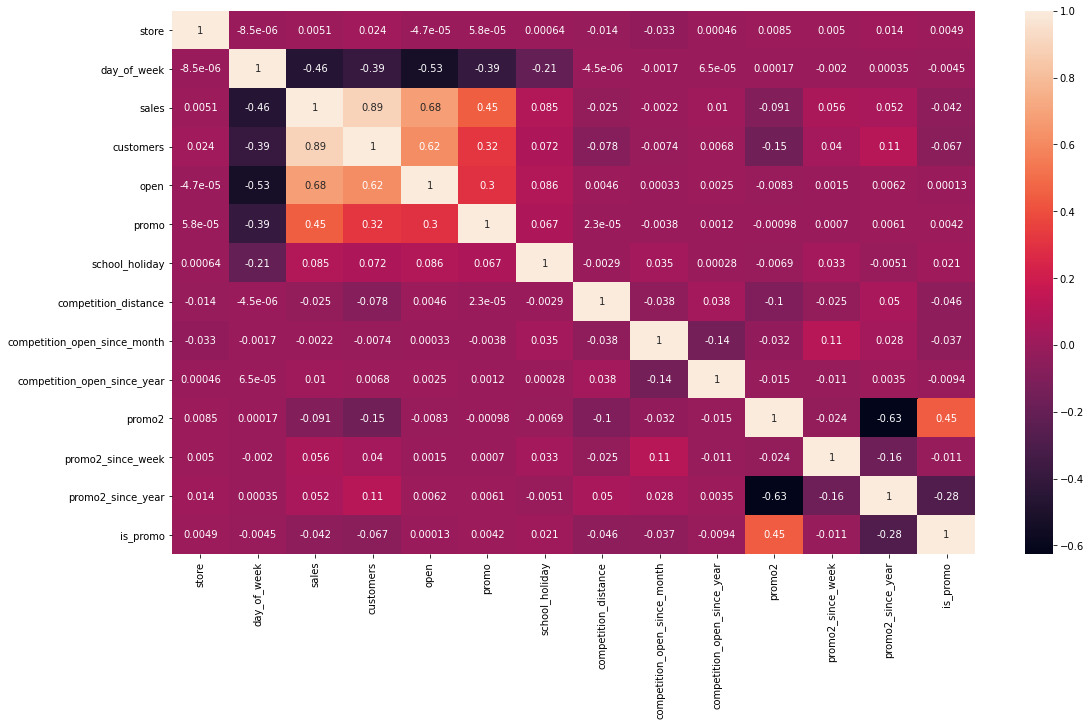

In [46]:
correlation = num_attributes.corr(method='pearson')
plt.figure(figsize=(18,10))
sns.heatmap(correlation, annot=True)

### 4.3.2 Categorial Attributes

In [47]:
#only categorical data
a = df4.select_dtypes(include='object')

a1 = cramer_v(a['state_holiday'], a['state_holiday'])
a2 = cramer_v(a['state_holiday'], a['store_type'])
a3 = cramer_v(a['state_holiday'], a['assortment'])

a4 = cramer_v(a['store_type'], a['state_holiday'])
a5 = cramer_v(a['store_type'], a['store_type'])
a6 = cramer_v(a['store_type'], a['assortment'])

a7 = cramer_v(a['assortment'], a['state_holiday'])
a8 = cramer_v(a['assortment'], a['store_type'])
a9 = cramer_v(a['assortment'], a['assortment'])

# results dataset
d = pd.DataFrame({'state_holiday': [a1,a2,a3],
              'store_type': [a4,a5,a6],
              'assortment': [a7,a8,a9],            
             })

d = d.set_index(d.columns)

<AxesSubplot:>

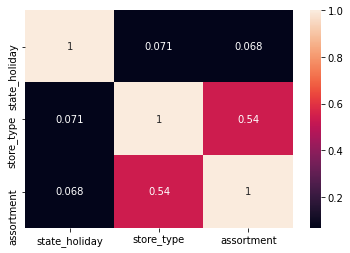

In [48]:
sns.heatmap(d, annot=True)

# 5. Data preparation

In [49]:
df5 = df4.copy()

## 5.1 Normalization

## 5.2 Rescaling

In [50]:
a = df5.select_dtypes(include=['int64','float64','int32','UInt32'])

In [51]:
rs = RobustScaler()
mms = MinMaxScaler()

# competition distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']].values)
pickle.dump(rs, open('parameter/competition_distance_scaler.pkl','wb'))

# competition time month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']].values)
pickle.dump(rs, open('parameter/competition_time_month_scaler.pkl','wb'))

# promo time week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']].values)
pickle.dump(rs, open('parameter/promo_time_week_scaler.pkl','wb'))

# year
df5['year'] = mms.fit_transform(df5[['year']].values)
pickle.dump(mms, open('parameter/year_scaler.pkl','wb'))

## 5.3 Transformation


### 5.3.1 Encoding

In [52]:
# state holiday - one hot encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

# store type - label encoding
le = LabelEncoder()
df5['store_type'] = le.fit_transform(df5['store_type'])
pickle.dump(le, open('parameter/store_type_scaler.pkl','wb'))

# assortment - ordinal encoding
assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
df5['assortment'] = df5['assortment'].map(assortment_dict)



In [53]:
df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,1,-0.170968,9,...,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,1,-0.283871,11,...,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,1,1.903226,12,...,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,3,-0.275806,9,...,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,1,4.448387,4,...,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,1,1,1,-0.351613,9,...,1,2013-00,2006-09-01,0.824324,2012-12-31,0.287016,0,0,1,0
1016827,733,2,2013-01-01,10765,0,1,1,2,-0.237097,10,...,1,2013-00,1999-10-01,1.959459,2012-12-31,0.287016,0,0,1,0
1016863,769,2,2013-01-01,5035,0,1,1,2,-0.240323,1,...,1,2013-00,2013-01-01,-0.216216,2012-11-19,0.300683,0,0,1,0
1017042,948,2,2013-01-01,4491,0,1,1,2,-0.145161,1,...,1,2013-00,2013-01-01,-0.216216,2012-12-31,0.287016,0,0,1,0


### 5.3.2 Response variable transformation

In [54]:
df5['sales'] = np.log1p(df5['sales'])

### 5.3.3 Nature transformation

In [55]:
# day of week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))
# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
# week of year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))

In [56]:
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,...,state_holiday_public_holiday,state_holiday_regular_day,day_of_week_sin,day_of_week_cos,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,...,0,1,-0.974928,-0.222521,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984


# 6.0 Feature selection

In [57]:
df6 = df5.copy()

## 6.1 Split dataframe into training and test dataset

In [58]:
cols_drop = ['week_of_year','day','month','day_of_week','promo_since','competition_since','year_week']
df6 = df6.drop(cols_drop, axis = 1)

In [59]:
df6[['store','date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days = 6*7)

Timestamp('2015-06-19 00:00:00')

In [60]:
X_train = df6[df6['date'] < '2015-06-19']
y_train = X_train['sales']

X_test = df6[df6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Training Min Date: {}'.format(X_train['date'].min()))
print('Training Max Date: {}'.format(X_train['date'].max()))

print('\nTest Min Date:{}'.format(X_test['date'].min()))
print('Test Max Date {}'.format(X_test['date'].max()))

Training Min Date: 2013-01-01 00:00:00
Training Max Date: 2015-06-18 00:00:00

Test Min Date:2015-06-19 00:00:00
Test Max Date 2015-07-31 00:00:00


## 6.2 Borutas as feature selector

In [61]:
# training and test dataset for Boruta
#X_train_n = X_train.drop(['date', 'sales'], axis=1).values
#y_train_n = y_train.values.ravel()

# define RandomForestRegressor
#rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
#boruta = BorutaPy(rf, n_estimators='auto',verbose=2,random_state=42).fit(X_train_n, y_train_n)


### 6.2.1 Best features from Boruta

In [62]:
#cols_selected = boruta.support_.tolist()
# best features
#X_train_fs = X_train.drop(['date', 'sales'], axis=1)
#cols_selected_boruta = X_train_fs.iloc[:, cols_selected].to_list()

#not selected boruta
#cols_not_selected_boruta = list( np.setdiff1d(x_train_fs.columns,cols_selected_boruta))

In [63]:
#cols_selected_boruta

In [64]:
#cols_not_selected_boruta

## 6.3 Manual feature selection

In [65]:
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'day_of_week_sin',
    'day_of_week_cos',
    'month_sin',
    'month_cos',
    'day_sin',
    'day_cos',
    'week_of_year_sin',
    'week_of_year_cos'
]

# columns to add

feature_to_add = ['date','sales']

# final features
cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend(feature_to_add)

# 7.0 Machine learning modelling

In [66]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

# time series data preparation
x_training = X_train[cols_selected_boruta_full]

## 7.1 Average model

In [67]:
aux1 = x_test.copy()
aux1['sales'] = y_test.copy()

# prediction
aux2 = aux1[['store','sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux1 = pd.merge(aux1, aux2, how='left', on='store')
yhat_baseline = aux1['predictions']

#performance
baseline_result = ml_error('Average model', np.expm1(y_test), np.expm1(yhat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average model,1354.800353,0.455051,1835.135542


## 7.2 Linear regression model

In [69]:
# model
lr = LinearRegression().fit(x_train, y_train)

# prediction
yhat_lr = lr.predict(x_test)

# performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(yhat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1867.089774,0.292694,2671.049215


### 7.2.1 Linear regression model cross-validation

In [70]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', lr, verbose = False)
lr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,2081.73 +/- 295.63,0.3 +/- 0.02,2952.52 +/- 468.37


## 7.3 Linear regression regularized model - Lasso

In [71]:
# model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# prediction
yhat_lrr = lrr.predict(x_test)

# performance
lrr_result = ml_error('Linear Regression - Lasso', np.expm1(y_test), np.expm1(yhat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,1891.704881,0.289106,2744.451737


### 7.3.1 Linear regression regularized - Lasso - cross-validation

In [72]:
lrr_result_cv = cross_validation(x_training,5,'Lasso',lrr,verbose=False)
lrr_result_cv

,Model name,MAE CV,MAPE CV,RMSE CV
0,Lasso,2116.38 +/- 341.5,0.29 +/- 0.01,3057.75 +/- 504.26


## 7.4 Random forest regressor

In [73]:
# model
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 42).fit(x_train, y_train)

# prediction
yhat_rf = rf.predict(x_test)

# performance
rf_result = ml_error('Random Forest', np.expm1(y_test), np.expm1(yhat_rf))
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest,679.598831,0.099913,1011.119437


In [74]:
rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
rf_result_cv


KFold Number: 5


KeyboardInterrupt: 

## 7.5 XGBoost Regressor

In [ ]:
# model
model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
                      n_estimators = 100, 
                      eta = 0.01, 
                      max_depth = 10, 
                      subsample = 0.7, 
                      colsample_bytree=0.9).fit(x_train, y_train)

# prediction
yhat_xgb = model_xgb.predict(x_test)

# performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb))
xgb_result

In [ ]:
xgb_result_cv = cross_validation(x_training, 5, 'XGBoos Regressor', model_xgb, verbose=True)
xgb_result_cv

## 7.6 Compare models performance

### 7.6.1 Single performance

In [ ]:
model_results = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
model_results.sort_values('RMSE')

### 7.6.2 Real performance

In [ ]:
model_results_cv = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
model_results_cv.sort_values('RMSE CV')

# 8.0 Hyperparameter fine tuning

## 8.1 Random search

In [ ]:
params = {
    'n_estimators': [1500, 1700, 2500, 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.7],
    'colsample_bytree': [0.3, 0.7, 0.9],
    'min_child_weight': [3, 8, 15]    
}
max_eval = 5

In [ ]:
#final_result = pd.DataFrame()

#for i in range(max_eval):
    
    # choose values for parameters randomly
#    hp = {k: random.sample(v,1)[0] for k, v in params.items()}
#    print(hp)
#    
    # model
#    model_xgb = xgb.XGBRegressor(objective = 'reg:squarederror', 
#                          n_estimators = hp['n_estimators'], 
#                          eta = hp['eta'], 
#                          max_depth = hp['max_depth'], 
#                          subsample = hp['subsample'], 
#                          colsample_bytree = hp['colsample_bytree'],
#                          min_child_weight = hp['min_child_weight'])

    
    # performance
#    result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
#    final_result = pd.concat([final_result, result])

#final_result

## 8.2 Final model

In [77]:
param_tuned = {
    'n_estimators': 2500,
    'eta': 0.03, 
    'max_depth': 9, 
    'subsample': 0.5, 
    'colsample_bytree': 0.7, 
    'min_child_weight': 3
}

In [78]:
# model
model_xgb_tuned = xgb.XGBRegressor(objective = 'reg:squarederror', 
                          n_estimators = param_tuned['n_estimators'], 
                          eta = param_tuned['eta'], 
                          max_depth = param_tuned['max_depth'], 
                          subsample = param_tuned['subsample'], 
                          colsample_bytree = param_tuned['colsample_bytree'],
                          min_child_weight = param_tuned['min_child_weight']).fit(x_train, y_train)

# prediction
yhat_xgb_tuned = model_xgb_tuned.predict(x_test)

# performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(yhat_xgb_tuned))
xgb_result_tuned

KeyboardInterrupt: 

In [79]:
pickle.dump(model_xgb_tuned, open('C:/Users/mahel/Envs/DScienceEmProd/DScienceEmProducao/model/model_rossmann.pkl','wb'))

NameError: name 'model_xgb_tuned' is not defined

# 9.0 Error interpretation

In [ ]:
df9 = X_test[cols_selected_boruta_full]

# rescale
df9['sales'] = np.expm1(df9.sales)
df9['predictions'] = np.expm1(yhat_xgb_tuned)

## 9.1 Business performance

In [ ]:
# sum of predictions
df91 = df9[['store','predictions']].groupby('store').sum().reset_index()

# MAE and MAPE
df9_aux1 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAE'})
df9_aux2 = df9[['store','sales','predictions']].groupby('store').apply( lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0: 'MAPE'})

# Merge
df9_aux3 = pd.merge(df9_aux1, df9_aux2, how='inner', on='store')
df92 = pd.merge(df91, df9_aux3, how='inner', on='store')

# scenarios
df92['worst_scenario'] = df92['predictions'] - df92['MAE']
df92['best_scenario'] = df92['predictions'] + df92['MAE']

# order columns
df92 = df92[['store', 'predictions', 'worst_scenario', 'best_scenario', 'MAE', 'MAPE']]

In [ ]:
df92.sort_values('MAPE', ascending=False).head()

In [ ]:
sns.scatterplot(x='store', y='MAPE',data=df92)

## 9.2 Total performance

In [ ]:
df93 = df92[['predictions', 'worst_scenario','best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenarios', 0: 'Values'})
df93['Values'] = df93['Values'].map('R$ {:,.2f}'.format)
df93

## 9.3 Machine learning performance

In [ ]:
df9['error'] = df9['sales'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['sales']

plt.figure(figsize=(18,10))

plt.subplot(2,2,1)
sns.lineplot(x='date', y='sales', data=df9, label='Sales')
sns.lineplot(x='date', y='predictions', data=df9, label='Predictions')

plt.subplot(2,2,2)
sns.lineplot(x='date', y='error_rate', data=df9)
plt.axhline(1, linestyle='--')

plt.subplot(2,2,3)
sns.distplot(df9['error'])

plt.subplot(2,2,4)
sns.scatterplot(df9['predictions'], df9['error'])


# 10. Deploy model to production

In [4]:
pickle.load(open('C:/Users/mahel/Envs/DScienceEmProd/DScienceEmProducao/model/model_rossmann.pkl','rb'))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.03, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.0299999993, max_delta_step=0, max_depth=9,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=2500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.5,
             tree_method='exact', validate_parameters=1, verbosity=None)

## 10.1 Rossman class

In [ ]:
import pickle
import inflection
import math
import pandas as pd
import numpy as np

class Rossmann(object):
    
    def __init__(self):
        self.home_path='C:/Users/mahel/Envs/DScienceEmProd/DScienceEmProducao/'
        self.competition_distance_scaler   = pickle.load(open(self.home_path + 'parameter/competition_distance_scaler.pkl','rb'))
        self.competition_time_month_scaler = pickle.load(open(self.home_path + 'parameter/competition_time_month_scaler.pkl','rb'))
        self.promo_time_week_scaler        = pickle.load(open(self.home_path + 'parameter/promo_time_week_scaler.pkl','rb'))
        self.year_scaler                   = pickle.load(open(self.home_path + 'parameter/year_scaler.pkl', 'rb'))
        self.store_type_scaler             = pickle.load(open(self.home_path + 'parameter/store_type_scaler.pkl','rb'))
    
    def data_cleaning(self, df1):

        ## 1.1 Rename Columns

        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo',
               'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
               'CompetitionDistance', 'CompetitionOpenSinceMonth',
               'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
               'Promo2SinceYear', 'PromoInterval']

        snakecase = lambda x: inflection.underscore(x)
       
        cols_new = list(map( snakecase, cols_old))
        
        #rename
        df1.columns = cols_new

        ## 1.3 Data Types
        df1['date'] = pd.to_datetime(df1['date'])
        
        ## 1.5 Fillout NA
        #competition distance
        df1.competition_distance.fillna(200000, inplace=True)

        #competition open since month
        df1.competition_open_since_month.fillna(df1.date.dt.month, inplace=True)

        #competition open since year
        df1.competition_open_since_year.fillna(df1.date.dt.year, inplace=True)

        #promo2 since week
        df1.promo2_since_week.fillna(df1.date.dt.isocalendar().week, inplace=True)

        #promo2 since year
        df1.promo2_since_year.fillna(df1.date.dt.year, inplace=True)

        #promo interval
        month_map = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'} 

        df1.promo_interval.fillna(0, inplace= True)

        df1['month_map'] = df1['date'].dt.month.map(month_map)

        df1['is_promo'] = df1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        ## 1.6 Change Types

        df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
        df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)
        df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
        df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)
        
        return df1

    def feature_engineering(self, df2):

        # year
        df2['year'] = df2['date'].dt.year

        # month
        df2['month'] = df2['date'].dt.month

        # day
        df2['day'] = df2['date'].dt.day

        # week of year
        df2['week_of_year'] = df2['date'].dt.isocalendar().week

        # year week
        df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

        # competition since
        df2['competition_since'] = df2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'],month=x['competition_open_since_month'],day=1), axis=1)
        df2['competition_time_month'] = ((df2['date'] - df2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        # promo since
        df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)
        df2['promo_since'] = df2.promo_since.apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))
        df2['promo_time_week'] = (( df2['date']-df2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        # assortment
        df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        # state holiday
        df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        ## 3.1 Filtering Lines

        df2 = df2[df2['open']  != 0]

        ## 3.2 Columns Selection

        cols_drop = ['open','promo_interval','month_map']
        df2 = df2.drop(cols_drop, axis = 1)
        
        return df2
    
    def data_preparation(self, df5, ft):
        
        ## 5.2 Rescaling

        # competition distance
        df5['competition_distance'] = self.competition_distance_saceler.fit_transform(df5[['competition_distance']].values)

        # competition time month
        df5['competition_time_month'] = self.competition_time_month.fit_transform(df5[['competition_time_month']].values)

        # promo time week
        df5['promo_time_week'] = self.promo_time_week.fit_transform(df5[['promo_time_week']].values)

        # year
        df5['year'] = mms.fit_transform(df5[['year']].values)

        ### 5.3.1 Encoding

        # state holiday - one hot encoding
        df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

        # store type - label encoding

        df5['store_type'] = self.store_type_scaler.fit_transform(df5['store_type'])


        # assortment - ordinal encoding
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df5['assortment'] = df5['assortment'].map(assortment_dict)

        ### 5.3.3 Nature transformation

        # day of week
        df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x * (2 * np.pi/7)))
        df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x * (2 * np.pi/7)))
       
        # month
        df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x * (2 * np.pi/12)))
        df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x * (2 * np.pi/12)))
        
        # day
        df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x * (2 * np.pi/30)))
        df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x * (2 * np.pi/30)))
        
        # week of year
        df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x * (2 * np.pi/52)))
        df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x * (2 * np.pi/52)))
        
        cols_selected_boruta = ['store','promo','store_type','assortment','competition_distance','competition_open_since_month','competition_open_since_year',
                                'promo2','promo2_since_week','promo2_since_year','competition_time_month','promo_time_week','day_of_week_sin','day_of_week_cos',
                                'month_sin','month_cos','day_sin','day_cos','week_of_year_sin','week_of_year_cos']
        return df5
    
    def get_prediction(self, model, original_data, test_data):
        pred = model.predict(test_data)

        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)

        return original_data.to_json(orient='records',date_format='iso')

## 10.2 API Handler

In [ ]:
import pickle
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loaging model

model = pickle.load(open('C:/Users/mahel/Envs/DScienceEmProd/DScienceEmProducao/model/model_rossmann.pkl','rb'))

# initialize AIP
app = Flask(__name__)

@app.route('/rossman/predict', methods=['POST'])
def rossman_predict():
    test_json = request.get_json()
    
    if test_json:
        if isinstance(test_json, dict): # unique
            test_raw = pd.DataFrame(test_json, index=[0])
        else:# multiple
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())
        
        # instantiate rossmann class
        
        pipeline = Rossmann()
        
        # data cleaning
        df1 = pipeline.data_cleaning(test_raw)
        # feature engineering
        df2 = pipeline.feature_engineering(df1)
        # data preparation
        df3 = pipeline.data_preparation(df2)        
        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df3)
        
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')
    

if __name__ == '__main__':
    app.run('127.0.0.1')

## 10.3 API Tester

In [5]:
df10 = pd.read_csv('C:/Users/mahel/Envs/DScienceEmProd/DScienceEmProducao/data/test.csv')

In [6]:
# merge test dataset + store
df_test = pd.merge(df10, df_store_raw, how = 'left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'] == 22]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [17]:
# convert daframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [23]:
#url = 'http://127.0.0.1:5000/rossmann/predict'
url = 'https://rossmann-ml-test.herokuapp.com/rossmann/predict'
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status code {}'.format(r.status_code))

Status code 503


In [90]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())

In [91]:
d2 = d1[['store','prediction']].groupby('store').sum().reset_index()

In [92]:
for i in range (len(d2)):
    print('Store number {} will sell {} in the next 6 weeks'.format(
        d2.loc[i,'store'],
        d2.loc[i, 'prediction']))

Store number 22 will sell 166960.31640625032 in the next 6 weeks


In [93]:
d2

,store,prediction
0,22,166960.316406
